Particle Swarm Optimization

For No of runs = 30, My algorithm tends to stabalize which is a good thing


In [0]:
!pip install pyclipper
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

     |████████████████████████████████| 133kB 4.7MB/s 


In [0]:
# PSO for maximin=zing plot fit

#! / Usr / bin / python
# - * - coding: Latin-1 - * -
# TP optim: surface maximization
# by the PSO algorithm
# Peio Loubiere for EISTI
# September 2017
#use: python surface.corr1.py
from scipy import *
from math import *
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import sys
import pyclipper
from functools import *
import numpy as np
import pandas as pd

# Visualization of the plot
#fig = plt.figure(figsize=(10,10))
#canv = fig.add_subplot(1,1,1)
#canv.set_xlim(0,500)
#canv.set_ylim(0,500)



# ***************** Paramètres du problème ******************
# Différent types of plots : 
#polygon = ((10,10),(10,400),(400,400),(400,10)) 
#polygon = ((10,10),(10,300),(250,300),(350,130),(200,10)) 
#polygon = ((50,150),(200,50),(350,150),(350,300),(250,300),(200,250),(150,350),(100,250),(100,200))
polygon = ((50,50),(50,400),(220,310),(220,170),(330,170),(330,480),(450,480),(450,50))

# ***********************************************************

# Transforms the polygon into a list for display.
def poly2list(polygon):
	polygonfig = list(polygon)
	polygonfig.append(polygonfig[0])
	return polygonfig

# Draw Constant polygon 
polygonfig = poly2list(polygon)

# Display visualization
def draw(polyfig,rectfig):
	global canv, codes
	canv.clear()
	canv.set_xlim(0,500)
	canv.set_ylim(0,500)
	# polygon figure
	codes = [Path.MOVETO]
	for i in range(len(polyfig)-2):
	  codes.append(Path.LINETO)   
	codes.append(Path.CLOSEPOLY)
	path = Path(polyfig, codes)
	patch = patches.PathPatch(path, facecolor='orange', lw=2)
	canv.add_patch(patch)

	# rectangle figure
	codes = [Path.MOVETO]
	for i in range(len(rectfig)-2):
		codes.append(Path.LINETO)
	codes.append(Path.CLOSEPOLY)
	path = Path(rectfig, codes)
	patch = patches.PathPatch(path, facecolor='grey', lw=2)
	canv.add_patch(patch)

	# Title(Area of Rectangle)
	plt.title("Max Area of my House: {}".format(round(area(rectfig[:-1]),2)))
	#plt.savefig('H:\plot'+str(runs)+'.png')
	#plt.clf()
	plt.pause(0.5)

def dispRes(best):
	print("Point = {}".format(best['pos']))
	print("rectangle coordinate = {}".format(pos2rect(best['pos'])))
	print("Best Area = {}".format(best['area']))	
	
def drawStats(Htemps, Hbest):
	# afFILEhage des courbes d'evolution
	fig = plt.figure(2,figsize=(10,10))
	#add_subplot(1,1,1)
	plt.semilogy(Htemps, Hbest)
	plt.title('Evolution of the best distance')
	plt.xlabel('Time')
	plt.ylabel('Area')

	#legend(mains, title='Optimization functions')
	#plt.tight_layout()
	#plt.show()
	#plt.savefig('H:/Desktop/land.png')
	
	
# Collect the boundaries of the bounding box around the parcel
def getbounds(polygon):
	lpoly = list(polygon) #tansformation into list for use with reduce function
	#return reduce(lambda (xmin,xmax,ymin,ymax),(xe,ye): (min(xe,xmin),max(xe,xmax),min(ye,ymin),max(ye,ymax)),lpoly[1:],(lpoly[0][0],lpoly[0][0],lpoly[0][1],lpoly[0][1]))
	return reduce(lambda acc,e: (min(e[0],acc[0]),max(e[0],acc[1]),min(e[1],acc[2]),max(e[1],acc[3])),lpoly[1:],(lpoly[0][0],lpoly[0][0],lpoly[0][1],lpoly[0][1]))

# Transformation of a solution of the pb (center / corner / angle) in rectangle for clipping
# Returns a rectangle (A (x1, y1), B (x2, y2), C (x3, y3), D (x4, y4))
def pos2rect(pos):
	# coin : point A
	xa, ya = pos[0], pos[1]
	# centre du rectangle : point O
	xo, yo = pos[2], pos[3]
	# angle  AÔD
	angle = pos[4]

	# point D : centre for rotation O, at the Angle alpha
	alpha = pi * angle / 180 # degre en radian
	xd = cos(alpha)*(xa-xo) - sin(alpha)*(ya-yo) + xo 
	yd = sin(alpha)*(xa-xo) + cos(alpha)*(ya-yo) + yo
	# point C : symétrique de A, de centre O
	xc, yc = 2*xo - xa, 2*yo - ya 
	# point B : symétrique de D, de centre O
	xb, yb = 2*xo - xd, 2*yo - yd

	# round for clipping
	return ((round(xa),round(ya)),(round(xb),round(yb)),(round(xc),round(yc)),(round(xd),round(yd)))

	
# Distance between 2 points (x1,y1), (x2,y2)
def distance(p1,p2):
	return sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

# Area of Rectangle (A (x1, y1), B (x2, y2), C (x3, y3), D (x4, y4))
# = distance AB * distance BC
def area(pos):
	edge1=(pos[0],pos[1])
	edge2=(pos[1],pos[2])
	#print(pos[0],pos[1],pos[2],pos[3])
	#print(distance(p1[0],p1[1])* distance(p2[0],p2[1]))
	return round(distance(edge1[0],edge1[1])* distance(edge2[0],edge2[1]),2)


# Clipping
# Predicate that verifies that the rectangle is in the polygon
# Test if
# - there is an intersection (! = []) between the figures and
# - the two lists are the same size and
# - all the points of the rectangle belong to the result of the clipping
# If error (~ flat angle), returns false

def verifyconstraint(rect, polygon):
	try:
		# Config
		pc = pyclipper.Pyclipper()
		pc.AddPath(polygon, pyclipper.PT_SUBJECT, True)
		pc.AddPath(rect, pyclipper.PT_CLIP, True)
		# Clipping
		clip = pc.Execute(pyclipper.CT_INTERSECTION, pyclipper.PFT_EVENODD, pyclipper.PFT_EVENODD)
		#all(iterable) return True if all elements of the iterable are true (or if the iterable is empty)		
		return (clip!=[]) and (len(clip[0])==len(rect)) and all(list(map(lambda e:list(e) in clip[0], rect)))
	except pyclipper.ClipperException:
		# print rect
		return False


# Create an individual (center / corner / angle) FEASABLE
# an individual is described by your metaheuristic containing at least:
# - pos: solution (center / corner / angle) list of variables
# - area: area of ​​the rectangle
# - ...: other components of the individual

def initUn(polygon):
	global xmin,xmax,ymin,ymax
	# xmin = 0
	# xmax = 500
	# ymin = 0
	# ymax = 500
	anglemin = 1.00
	anglemax = 90.00
	boolOK = False
	pos = []
	while not boolOK: # as long as it is not feasible
		xo=random.uniform(xmin,xmax)
		yo=random.uniform(ymin,ymax)
		
		xa=xo+pow(-1,random.randint(0,1))*random.uniform(10,min(xo-xmin,xmax-xo))
		ya=yo+pow(-1,random.randint(0,1))*random.uniform(10,min(yo-ymin,ymax-yo))
		angle = random.uniform(anglemin,anglemax)

		pos = [round(xa),round(ya),round(xo),round(yo),angle]
		rect = pos2rect(pos)
		#print(rect)
		# calcul du clipping
		boolOK = verifyconstraint(rect,polygon)
	ev = round(area(pos2rect(pos)),2)
	return {'vit':[0]*dim, 'pos':pos, 'area':ev ,'bestpos':pos, 'bestarea':ev, 'bestvois':[]}

# Initialization of the population
def initPop(nb,polygon):
	return [initUn(polygon) for i in range(nb)]

# Returns the best particle between two: depends on the metaheuristic
def bestPartic(p1,p2):
	#print('comparison')
	#print('------------------------')
	#print(p1)
	#print('------------------------')
	#breakpoint()
	if (p1["area"] < p2["area"]):
		return p2 
	else:
		return p1
	
# Return a copy of the best particle of the population
def getBest(population):
	#print(dict(reduce(lambda acc, e: bestPartic(acc,e),population[1:],population[0])))
	return dict(reduce(lambda acc, e: bestPartic(acc,e),population[1:],population[0]))


#"""
#PSO ALGORITH IMPLEMENTATION
#"""
		

# Initialization of the population (swarm)
def initSwarm(nb,polygon):
	return [initUn(polygon) for i in range(nb)]


# # Return the particle with the best fitness
# def maxParticle(p1, p2):
	# if (p1["area"] < p2["area"]):
		# return p1
	# else:
		# return p2

# Calculate the velocity and move a paticule
def move(particle,dim):
	global c1,c2,psi,cmax

	nv = dict(particle)
	#everytime a new dictionary is created for the single particle of swarm
	#print('--------------------******************-----------')
	#print(nv)
	#break;
	#velocity for 5 parameters
	velocity = [0]*dim
	for i in range(dim):
		velocity[i] = (particle["vit"][i]*psi + \
		cmax*random.uniform()*(particle["bestpos"][i] - particle["pos"][i]) + \
		cmax*random.uniform()*(particle["bestvois"][i] - particle["pos"][i]))
	position = [0]*dim
	for i in range(dim):
		position[i] = particle["pos"][i] + velocity[i]
		#if i==4:
			#position[i] = round(particle["pos"][i] + velocity[i])
	# New position might contradict my dimension constraint
	# i need to verify that cordinates and angle give me a rectangle 
	# which lies in the polgon plot of land
	#print("the angle is ")
	#print(position[4])
	if (position[4] <1.00 or position[4]>90.00):
		position[4] = particle["pos"][4]
		#move(particle,dim)
	if (verifyconstraint(pos2rect(position),polygon) == False): 
		position = particle["pos"]
	#breakpoint()
	nv['vit'] = velocity
	nv['pos'] = position
	nv['area'] = round(area(pos2rect(position)),2)
	return nv		
		
# Update information for the particles of the population (swarm)
def update(particle,bestParticle):
	nv = dict(particle)
	#print('--******************************************---')
	#print(particle["area"])
	#print(particle["bestarea"])
	#print(nv)
	#print('--******************************************---')
	#breakpoint()
	if(particle["area"] > particle["bestarea"]):
		nv['bestpos'] = particle["pos"][:]
		nv['bestarea'] = particle["area"]
	nv['bestvois'] = bestParticle["bestpos"][:]
	#print(nv)
	#breakpoint()
	return nv		
		
		
		
		


# ************ Parameters of the metaheuristic *** PSO = 10000 DE = 1500 ********* NB indiv 20 *
Nb_cycles = 10000
Nb_Indiv = 20

# ***********************************************************
global DIM,dim
DIM = 5
dim = 5
# usual params
psi, cmax = (0.4, 1.41)


# xmin,xmax,ymin,ymax = getbounds(polygon)
# #print(xmin,xmax,ymin,ymax)

# # initialisation of the population (of the agent if simulated annealing) and the best individual.
# swarm = initPop(Nb_Indiv,polygon)
# print('initial swarm')
# #print(swarm)
# #breakpoint()
# best = getBest(swarm)
# #print(best)
# print('------best out of swarm--------')
# best_plot = best
# print(best_plot)
# #breakpoint()
# # -------- Code is working fine till here --------------


final = pd.DataFrame()
areali = []
coordli = []

Nb_runs = 30
best_areas = []
best_rectangles = []
for runs in range(Nb_runs):
# --------------------------------------------------
	Htemps = []       # temps
	Hbest = []
	xmin,xmax,ymin,ymax = getbounds(polygon)
	#print(xmin,xmax,ymin,ymax)

	# initialisation of the population (of the agent if simulated annealing) and the best individual.
	swarm = initPop(Nb_Indiv,polygon)
	#print('initial swarm')
	#print(swarm)
	#breakpoint()
	best = getBest(swarm)
	#print(best)
	#print('------best out of swarm--------')
	best_plot = best
	#print(best_plot)
#breakpoint()
# -------- Code is working fine till here --------------
#---------------------------------------------------

	#print("Run no. {}".format(runs))
	for i in range(Nb_cycles):
		#Update informations
		#print("  Current Cycle is  {}".format(i))
		swarm = [update(e,best_plot) for e in swarm]
		#print('iterative swarm')
		#print(swarm)
		#breakpoint()
		# velocity calculations and displacement
		swarm = [move(e,DIM) for e in swarm]
		# Update of the best solution
		#print('printing all the swarms')
		#print(swarm)
		best_plot = getBest(swarm)
		#print("---------------best_plot VS best--------------------")
		#print("{}  V/S {}".format(best_plot['area']).format(best['area']))
		#print(best)
		#print('printing the best plot')
		#print(best_plot)


		if (best_plot["area"] > best["area"]):
			best = best_plot
			# draw(best['pos'], best['fit'])
		#print("---------------And the best is --------------------")
		#print(best['area'])
		coordli.append(best['pos'])
		areali.append(best['area'])
		#breakpoint()
		# historization of data
		if i % 10 == 0:
			Htemps.append(i)
			Hbest.append(best['area'])

		# # swarm display
		# if i % 10 == 0:
			# draw(swarm,i)

	# END, displaying results
	Htemps.append(i)
	Hbest.append(best['area'])

	#dispRes(best)
 
	#print(pos2rect(best["pos"]))
	#print(area(pos2rect(best["pos"])))
	best_areas.append(best['area'])
	best_rectangles.append(pos2rect(best['pos']))
	#draw(polygonfig, poly2list(pos2rect(best["pos"])))
	#plt.show()
	#fig.clf()
	#plt.close()
	#displaying result on the console
	#drawStats(Htemps, Hbest)	
	#"""
	#END OF PSO ALGORITHM
	#"""
	#for i in range(Nb_cycles):
	#	print("the best area at the {} iteration with the coordinates {} is  {}.m^2 " .format(i,coordli[i],areali[i]))
	

final['Best Coordinate']= best_rectangles
final['Best Area']= best_areas

In [0]:
final

,Best Coordinate,Best Area
0,"((450, 480), (450, 50), (330, 51), (331, 480))",51601.79
1,"((449, 471), (450, 50), (330, 50), (330, 470))",50520.14
2,"((219, 310), (221, 50), (51, 50), (50, 309))",44201.31
3,"((220, 261), (220, 50), (50, 51), (50, 261))",35870.62
4,"((179, 332), (181, 50), (51, 50), (50, 332))",36660.92
5,"((449, 480), (450, 50), (330, 50), (330, 480))",51600.14
6,"((219, 307), (221, 50), (51, 50), (50, 306))",43691.32
7,"((450, 403), (450, 50), (330, 51), (330, 403))",42361.47
8,"((449, 480), (450, 50), (330, 50), (330, 480))",51600.14
9,"((449, 439), (450, 50), (330, 50), (330, 438))",46680.15


In [0]:
final.to_excel("H:\Desktop\Area1.xlsx", sheet_name='Sheet_1', na_rep='', float_format=None, columns=['Best Retangle','Best Area'], header=True, index=True, index_label = None)

/usr/local/lib/python3.6/dist-packages/pandas/io/formats/excel.py:400: FutureWarning: Not all names specified in 'columns' are found; this will raise a KeyError in the future
  FutureWarning,


In [0]:
top =  final[final['Best Area'] == (max(final['Best Area']))]
tops = top['Best Coordinate'].iloc[0]
topa = top['Best Area'].iloc[0]
top

,Best Coordinate,Best Area
11,"((450, 480), (449, 50), (329, 51), (331, 480))",51601.93
13,"((450, 480), (449, 50), (329, 51), (331, 480))",51601.93
16,"((450, 480), (449, 50), (329, 51), (331, 480))",51601.93
24,"((450, 480), (449, 50), (329, 51), (331, 480))",51601.93


(0, 500)

(0, 500)

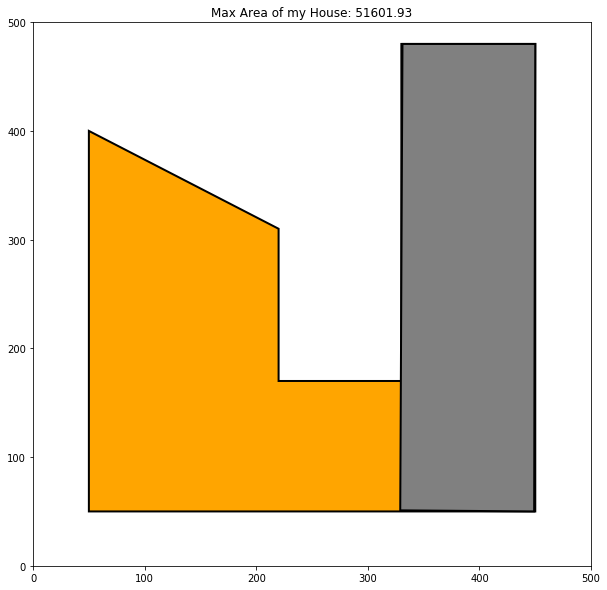

In [0]:
# Visualization Best plot
fig = plt.figure(figsize=(10,10))
canv = fig.add_subplot(1,1,1)
canv.set_xlim(0,500)
canv.set_ylim(0,500)
draw(polygonfig, poly2list(top['Best Coordinate'].iloc[0]))

<Figure size 1080x360 with 0 Axes>

(0, 32)

([<matplotlib.axis.XTick at 0x7ff812ce34e0>,
 <a list of 31 Text xticklabel objects>)

Text(0.5, 1.0, 'The Best Area for every Algorithm run')

Text(0.5, 0, 'Runs of Algorithm')

Text(0, 0.5, 'Area')

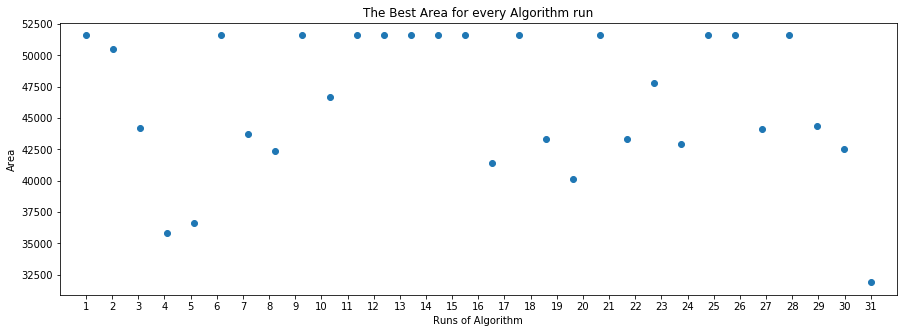

In [0]:
plt.figure(figsize=(15,5))
plt.xlim(0,32)
plt.xticks(np.arange(1,32,1))
plt.title('The Best Area for every Algorithm run')
plt.xlabel('Runs of Algorithm')
plt.ylabel('Area')
plt.scatter(linspace(1,31,num=30), final['Best Area'])

In [0]:
Nb_Runs = np.arange(1, 31, 1)
#xi = list(range(len(Nb_Runs)))
maxi = area(polygon)

In [0]:
from statistics import *
print('Best of Best')
print('Mean is : {}'.format(round(mean(best_areas),2)))
print('Standard deviation : {} '.format(round(stdev(best_areas),2)))

Best of Best
Mean is : 46419.13
Standard deviation : 5677.72 


In [0]:
accuracy = [round(((e*100)/topa),1) for e in best_areas]
print(accuracy)

[100.0, 97.9, 85.7, 69.5, 71.0, 100.0, 84.7, 82.1, 100.0, 90.5, 100.0, 100.0, 100.0, 100.0, 100.0, 80.3, 100.0, 83.9, 77.8, 100.0, 83.9, 92.6, 83.2, 100.0, 100.0, 85.5, 100.0, 86.0, 82.5, 61.8]


<Figure size 1080x360 with 0 Axes>

(0, 31)

([<matplotlib.axis.XTick at 0x7ff812bec048>,
 <a list of 30 Text xticklabel objects>)

Text(0.5, 1.0, 'The Best Area for every Algorithm run')

Text(0.5, 0, 'Runs of Algorithm')

Text(0, 0.5, 'Accuracy of algorithm')

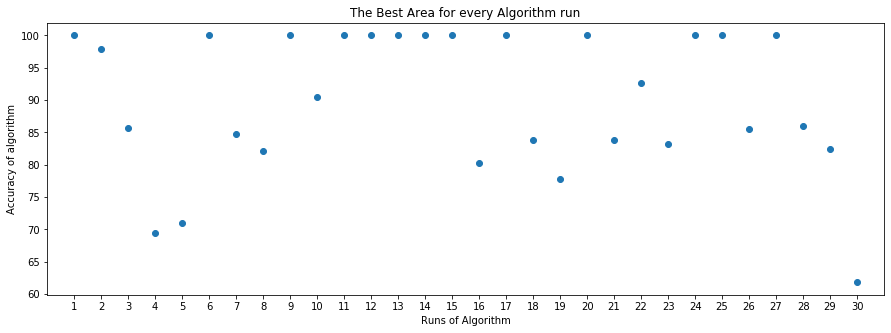

In [0]:
plt.figure(figsize=(15,5))
plt.xlim(0,31)
plt.xticks(np.arange(min(Nb_Runs), max(Nb_Runs)+1, 1.0))
plt.title('The Best Area for every Algorithm run')
plt.xlabel('Runs of Algorithm')
plt.ylabel('Accuracy of algorithm')
plt.scatter(Nb_Runs,accuracy)
plt.show()

In [0]:
# Mean Accuracy
print('Mean Accuracy : {}'.format(mean(accuracy)))

Mean Accuracy : 89.96333333333334


{'boxes': [<matplotlib.lines.Line2D at 0x7ff812e56b00>],
 'caps': [<matplotlib.lines.Line2D at 0x7ff812e56e48>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff812e35ef0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7ff812e35dd8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7ff812e56438>,
  <matplotlib.lines.Line2D at 0x7ff812e56978>]}

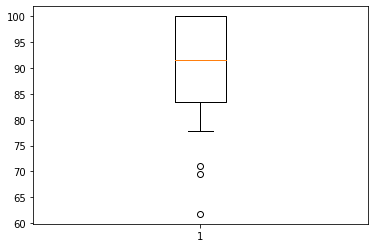

In [0]:
plt.boxplot(accuracy,whis= 0.5)

### FOR SINGLE RUN OF ALGORITHM

(0, 500)

(0, 500)

Point = [393.296495800775, 400.00035814074266, 201.89479141926904, 204.80531532358137, 88.99594823085317]
rectangle coordinate = ((393, 400), (394, 10), (10, 10), (10, 400))
Best Area = 149760.49


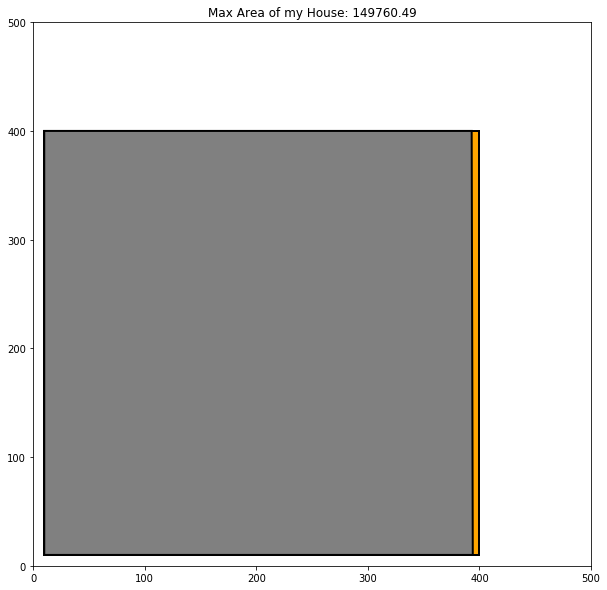

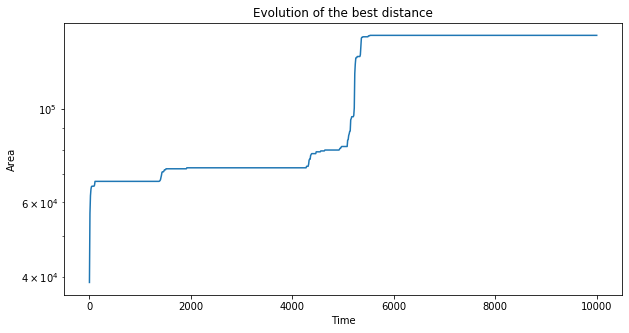

In [0]:

#! / Usr / bin / python
# - * - coding: Latin-1 - * -
# TP optim: surface maximization
# by the PSO algorithm
# Peio Loubiere for EISTI
# September 2017
#use: python surface.corr1.py
from scipy import *
from math import *
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import sys
import pyclipper
from functools import *
import numpy as np

# Visualization of the plot
fig1 = plt.figure(figsize=(10,10))
canv = fig1.add_subplot(1,1,1)
canv.set_xlim(0,500)
canv.set_ylim(0,500)



# ***************** Paramètres du problème ******************
# Différent types of plots : 
polygon = ((10,10),(10,400),(400,400),(400,10)) 
# polygon = ((10,10),(10,300),(250,300),(350,130),(200,10)) 
#polygon = ((50,150),(200,50),(350,150),(350,300),(250,300),(200,250),(150,350),(100,250),(100,200))
#polygon = ((50,50),(50,400),(220,310),(220,170),(330,170),(330,480),(450,480),(450,50))

# ***********************************************************

# Transforms the polygon into a list for display.
def poly2list(polygon):
	polygonfig = list(polygon)
	polygonfig.append(polygonfig[0])
	return polygonfig

# Draw Constant polygon 
polygonfig = poly2list(polygon)

# Display visualization
def draw(polyfig,rectfig):
	global canv, codes
	canv.clear()
	canv.set_xlim(0,500)
	canv.set_ylim(0,500)
	# polygon figure
	codes = [Path.MOVETO]
	for i in range(len(polyfig)-2):
	  codes.append(Path.LINETO)   
	codes.append(Path.CLOSEPOLY)
	path = Path(polyfig, codes)
	patch = patches.PathPatch(path, facecolor='orange', lw=2)
	canv.add_patch(patch)

	# rectangle figure
	codes = [Path.MOVETO]
	for i in range(len(rectfig)-2):
	  codes.append(Path.LINETO)   
	codes.append(Path.CLOSEPOLY)
	path = Path(rectfig, codes)
	patch = patches.PathPatch(path, facecolor='grey', lw=2)
	canv.add_patch(patch)

	# Title(Area of Rectangle)
	plt.title("Max Area of my House: {}".format(round(area(rectfig[:-1]),2)))
	plt.draw()
 	#plt.savefig('H:/Desktop/Hproject/Plot.png')
	plt.pause(0.1)

def dispRes(best):
	print("Point = {}".format(best['pos']))
	print("rectangle coordinate = {}".format(pos2rect(best['pos'])))
	print("Best Area = {}".format(best['area']))	
	
def drawStats(Htemps, Hbest):
	# afFILEhage des courbes d'evolution
	fig = plt.figure(2,figsize=(10,5))
	#add_subplot(1,1,1)
	plt.semilogy(Htemps, Hbest)
	plt.title('Evolution of the best distance')
	plt.xlabel('Time')
	plt.ylabel('Area')

	#legend(mains, title='Optimization functions')
	#plt.tight_layout()
	#plt.show()
	plt.savefig('H:\Desktop\Hproject\Converging_Area.png')
	
	
# Collect the boundaries of the bounding box around the parcel
def getbounds(polygon):
	lpoly = list(polygon) #tansformation into list for use with reduce function
	#return reduce(lambda (xmin,xmax,ymin,ymax),(xe,ye): (min(xe,xmin),max(xe,xmax),min(ye,ymin),max(ye,ymax)),lpoly[1:],(lpoly[0][0],lpoly[0][0],lpoly[0][1],lpoly[0][1]))
	return reduce(lambda acc,e: (min(e[0],acc[0]),max(e[0],acc[1]),min(e[1],acc[2]),max(e[1],acc[3])),lpoly[1:],(lpoly[0][0],lpoly[0][0],lpoly[0][1],lpoly[0][1]))

# Transformation of a solution of the pb (center / corner / angle) in rectangle for clipping
# Returns a rectangle (A (x1, y1), B (x2, y2), C (x3, y3), D (x4, y4))
def pos2rect(pos):
	# coin : point A
	xa, ya = pos[0], pos[1]
	# centre du rectangle : point O
	xo, yo = pos[2], pos[3]
	# angle  AÔD
	angle = pos[4]

	# point D : centre for rotation O, at the Angle alpha
	alpha = pi * angle / 180 # degre en radian
	xd = cos(alpha)*(xa-xo) - sin(alpha)*(ya-yo) + xo 
	yd = sin(alpha)*(xa-xo) + cos(alpha)*(ya-yo) + yo
	# point C : symétrique de A, de centre O
	xc, yc = 2*xo - xa, 2*yo - ya 
	# point B : symétrique de D, de centre O
	xb, yb = 2*xo - xd, 2*yo - yd

	# round for clipping
	return ((round(xa),round(ya)),(round(xb),round(yb)),(round(xc),round(yc)),(round(xd),round(yd)))

	
# Distance between 2 points (x1,y1), (x2,y2)
def distance(p1,p2):
	return sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

# Area of Rectangle (A (x1, y1), B (x2, y2), C (x3, y3), D (x4, y4))
# = distance AB * distance BC
def area(pos):
	edge1=(pos[0],pos[1])
	edge2=(pos[1],pos[2])
	#print(pos[0],pos[1],pos[2],pos[3])
	#print(distance(p1[0],p1[1])* distance(p2[0],p2[1]))
	return round(distance(edge1[0],edge1[1])* distance(edge2[0],edge2[1]),2)

# Clipping
# Predicate that verifies that the rectangle is in the polygon
# Test if
# - there is an intersection (! = []) between the figures and
# - the two lists are the same size and
# - all the points of the rectangle belong to the result of the clipping
# If error (~ flat angle), returns false

def verifyconstraint(rect, polygon):
	try:
		# Config
		pc = pyclipper.Pyclipper()
		pc.AddPath(polygon, pyclipper.PT_SUBJECT, True)
		pc.AddPath(rect, pyclipper.PT_CLIP, True)
		# Clipping
		clip = pc.Execute(pyclipper.CT_INTERSECTION, pyclipper.PFT_EVENODD, pyclipper.PFT_EVENODD)
		#all(iterable) return True if all elements of the iterable are true (or if the iterable is empty)		
		return (clip!=[]) and (len(clip[0])==len(rect)) and all(list(map(lambda e:list(e) in clip[0], rect)))
	except pyclipper.ClipperException:
		# print rect
		return False


# Create an individual (center / corner / angle) FEASABLE
# an individual is described by your metaheuristic containing at least:
# - pos: solution (center / corner / angle) list of variables
# - area: area of ​​the rectangle
# - ...: other components of the individual

def initUn(polygon):
	global xmin,xmax,ymin,ymax
	anglemin = 1.00
	anglemax = 89.00
	boolOK = False
	pos = []
	while not boolOK: # as long as it is not feasible
		xo=random.uniform(xmin,xmax)
		yo=random.uniform(ymin,ymax)
		
		xa=xo+pow(-1,random.randint(0,1))*random.uniform(10,min(xo-xmin,xmax-xo))
		ya=yo+pow(-1,random.randint(0,1))*random.uniform(10,min(yo-ymin,ymax-yo))
		angle = random.uniform(anglemin,anglemax)

		pos = [round(xa),round(ya),round(xo),round(yo),angle]
		rect = pos2rect(pos)
		#print(rect)
		# calcul du clipping
		boolOK = verifyconstraint(rect,polygon)
	ev = round(area(pos2rect(pos)),2)
	return {'vit':[0]*dim, 'pos':pos, 'area':ev ,'bestpos':pos, 'bestarea':ev, 'bestvois':[]}

# Initialization of the population
def initPop(nb,polygon):
	return [initUn(polygon) for i in range(nb)]

# Returns the best particle between two: depends on the metaheuristic
def bestPartic(p1,p2):
	#print('comparison')
	#print('------------------------')
	#print(p1)
	#print('------------------------')
	#breakpoint()
	if (p1["area"] < p2["area"]):
		return p2 
	else:
		return p1
	
# Return a copy of the best particle of the population
def getBest(population):
	#print(dict(reduce(lambda acc, e: bestPartic(acc,e),population[1:],population[0])))
	return dict(reduce(lambda acc, e: bestPartic(acc,e),population[1:],population[0]))


#"""
#PSO ALGORITH IMPLEMENTATION
#"""
		

# Initialization of the population (swarm)
def initSwarm(nb,polygon):
	return [initUn(polygon) for i in range(nb)]


# # Return the particle with the best fitness
# def maxParticle(p1, p2):
	# if (p1["area"] < p2["area"]):
		# return p1
	# else:
		# return p2

# Calculate the velocity and move a paticule
def move(particle,dim):
	global c1,c2,psi,cmax

	nv = dict(particle)
	#everytime a new dictionary is created for the single particle of swarm
	#print('--------------------******************-----------')
	#print(nv)
	#break;
	#velocity for 5 parameters
	velocity = [0]*dim
	for i in range(dim):
		velocity[i] = (particle["vit"][i]*psi + \
		cmax*random.uniform()*(particle["bestpos"][i] - particle["pos"][i]) + \
		cmax*random.uniform()*(particle["bestvois"][i] - particle["pos"][i]))
	position = [0]*dim
	for i in range(dim):
		position[i] = particle["pos"][i] + velocity[i]
		#if i==4:
			#position[i] = round(particle["pos"][i] + velocity[i])
	# New position might contradict my dimension constraint
	# i need to verify that cordinates and angle give me a rectangle 
	# which lies in the polgon plot of land
	#print("the angle is ")
	#print(position[4])
	if (position[4] <1.00 or position[4]>89.00):
		position = particle["pos"]
		#move(particle,dim)
	if (verifyconstraint(pos2rect(position),polygon) == False): 
		position = particle["pos"]
	#breakpoint()
	nv['vit'] = velocity
	nv['pos'] = position
	nv['area'] = round(area(pos2rect(position)),2)
	return nv		
		
# Update information for the particles of the population (swarm)
def update(particle,bestParticle):
	nv = dict(particle)
	#print('--******************************************---')
	#print(particle["area"])
	#print(particle["bestarea"])
	#print(nv)
	#print('--******************************************---')
	#breakpoint()
	if(particle["area"] > particle["bestarea"]):
		nv['bestpos'] = particle["pos"][:]
		nv['bestarea'] = particle["area"]
	nv['bestvois'] = bestParticle["bestpos"][:]
	#print(nv)
	#breakpoint()
	return nv		
		
		
		
		
Htemps = []       # temps
Hbest = []

# ************ Parameters of the metaheuristic *** PSO = 10000 DE = 1500 ********* NB indiv 20 *
Nb_cycles = 10000
Nb_Indiv = 20

# ***********************************************************
global DIM,dim
DIM = 5
dim = 5
# usual params
psi, cmax = (0.4, 1.41)


xmin,xmax,ymin,ymax = getbounds(polygon)
#print(xmin,xmax,ymin,ymax)

# initialisation of the population (of the agent if simulated annealing) and the best individual.
swarm = initPop(Nb_Indiv,polygon)
#print('initial swarm')
#print(swarm)
#breakpoint()
best = getBest(swarm)
#print(best)
#print('------best out of swarm--------')
best_plot = best
#print(best_plot)
#breakpoint()
# -------- Code is working fine till here --------------



areali = []
coordli = []

for i in range(Nb_cycles):
	#Update informations
	#print("  Current Cycle is  {}".format(i))
	swarm = [update(e,best_plot) for e in swarm]
	#print('iterative swarm')
	#print(swarm)
	#breakpoint()
	# velocity calculations and displacement
	swarm = [move(e,DIM) for e in swarm]
	# Update of the best solution
	#print('printing all the swarms')
	#print(swarm)
	best_plot = getBest(swarm)
	#print("---------------best_plot VS best--------------------")
	#print("{}  V/S {}".format(best_plot['area']).format(best['area']))
	#print(best)
	#print('printing the best plot')
	#print(best_plot)


	if (best_plot["area"] > best["area"]):
		best = best_plot
		# draw(best['pos'], best['fit'])
	#print("---------------And the best is --------------------")
	#print(best['area'])
	coordli.append(best['pos'])
	areali.append(best['area'])
	#breakpoint()
	# historization of data
	if i % 10 == 0:
		Htemps.append(i)
		Hbest.append(best['area'])

	# # swarm display
	# if i % 10 == 0:
		# draw(swarm,i)

# END, displaying results
Htemps.append(i)
Hbest.append(best['area'])
dispRes(best)
#print(pos2rect(best["pos"]))
#print(area(pos2rect(best["pos"])))
draw(polygonfig, poly2list(pos2rect(best["pos"])))
plt.show()		
#displaying result on the console
drawStats(Htemps, Hbest)	
#"""
#END OF PSO ALGORITHM
#"""
#for i in range(Nb_cycles):
#	print("the best area at the {} iteration with the coordinates {} is  {}.m^2 " .format(i,coordli[i],areali[i]))




Text(0.5, 1.0, 'Evolution of the best distance')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Area')

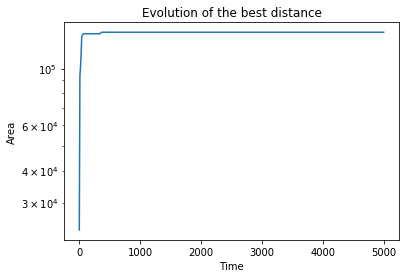

In [0]:
plt.semilogy(Htemps, Hbest)
plt.title('Evolution of the best distance')
plt.xlabel('Time')
plt.ylabel('Area')

#legend(mains, title='Optimization functions')
#plt.tight_layout()
plt.show()
#plt.savefig('H:/Desktop/land.png')